## Question 1 (Adaptive time stepping)

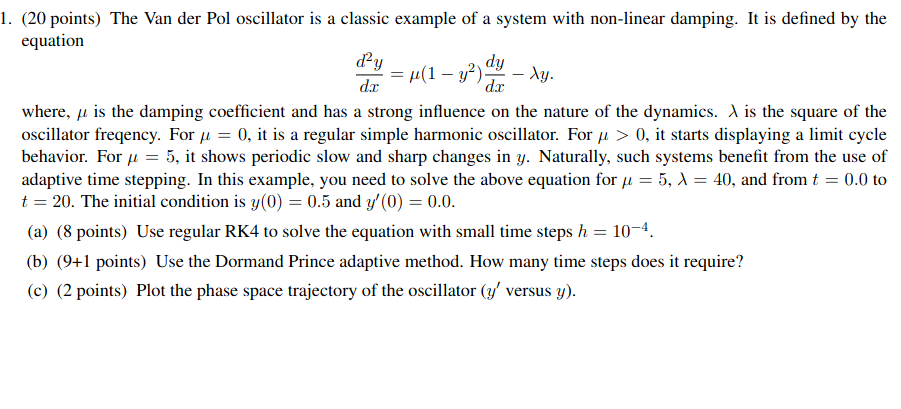

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Regular rk4


In [161]:
def rk4(f, x, y, h):
    
    k1 = h * f(x, y)
    k2 = h * f(x + h / 2, y + k1 / 2)
    k3 = h * f(x + h / 2, y + k2 / 2)
    k4 = h * f(x + h, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def call_method(method,f,y_in,N,xs,h):
    
    y = y_in
    
    ys = np.zeros((N,len(y_in)),dtype = np.float64)
    
    for i in range(N):
        x= xs[i]
        ys[i,:] = y
        
        y = method(f,x,y,h)
    return ys


The ODE is:

$$     \dfrac{d^2y}{dx^2} = \mu (1-y^2)\dfrac{dy}{dx} -\lambda y $$

into  single order :
$$  \dfrac{dy}{dx} = v    \qquad \dfrac{dv}{dx} = \mu (1-y^2)v -\lambda y    $$

In [162]:
def f(x,y):
    return np.asarray([y[1], mu*(1-y[0]**2)*y[1] - Lambda*y[0] ])

mu = 5
Lambda = 40

h = 10**(-4)

# Time span 
x0 = 0.0
xT = 20.0

# Generate x values (for plotting and comparison)
xs = np.arange(x0, xT, h)
N = len(xs)

# Initialize y
y_ini = np.asarray([0.5,0])

ysrk4 = call_method(rk4,f,y_ini,N,xs,h)
pos = ysrk4[:,0]
der = ysrk4[:,1]

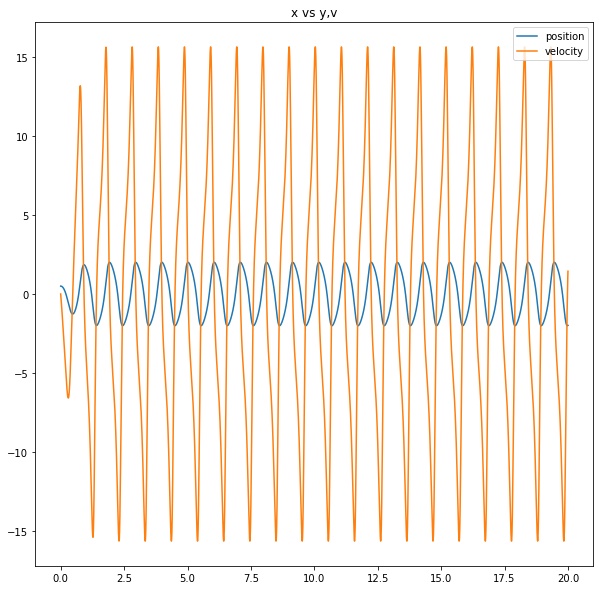

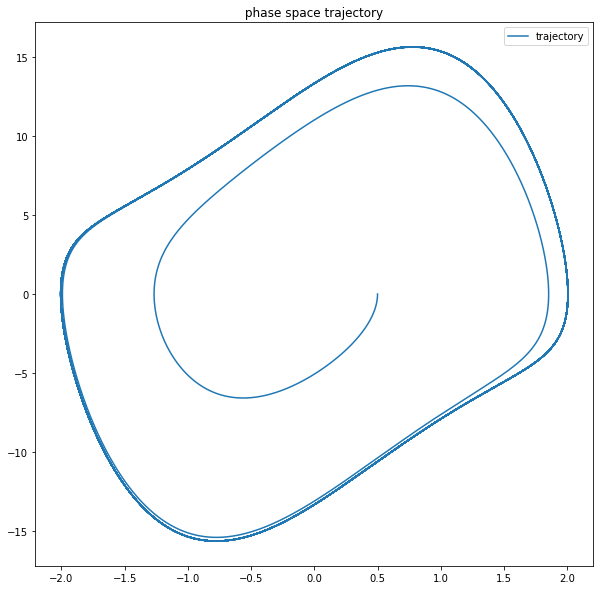

In [163]:
fig ,ax = plt.subplots(figsize = (10,10))
ax.plot(xs,pos,label = "position")
ax.plot(xs,der,label = "velocity")
plt.legend(loc='upper right')
ax.set_title("x vs y,v")
plt.show()

fig ,ax = plt.subplots(figsize = (10,10))
ax.plot(pos,der,label="trajectory")
plt.legend()
ax.set_title(" phase space trajectory ")
plt.show()

## Using Dormand-Prince  Method

In [164]:
# Dormand-Prince in matrix form
a = [0.2, 0.3, 0.8, 8/9, 1.0, 1.0]
b = [
    [1/5, 0, 0, 0, 0, 0],
    [3/40, 9/40, 0, 0, 0, 0],
    [44/45, -56/15, 32/9, 0, 0, 0],
    [19372/6561, -25360/2187, 64448/6561, -212/729, 0, 0],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]
]
c = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]

# Dormand-Prince
a2 = 1/5;  b21 = 1/5;
a3 = 3/10; b31 = 3/40;       b32 = 9/40;
a4 = 4/5;  b41 = 44/45;      b42 = -56/15;      b43 = 32/9;
a5 = 8/9;  b51 = 19372/6561; b52 = -25360/2187; b53 = 64448/6561; b54 =-212/729;
a6 = 1;    b61 = 9017/3168;  b62 = -355/33;     b63 = 46732/5247; b64 = 49/176;  b65 = -5103/18656;
a7 = 1;    b71 = 35/384;     b72 = 0;           b73 = 500/1113;   b74 = 125/192; b75 = -2187/6784;  b76 = 11/84;

c1 = 35/384; c2 = 0; c3 = 500/1113; c4 = 125/192; c5=-2187/6784; c6 = 11/84; c7 = 0;
c1s = 5179/57600; c2s = 0; c3s = 7571/16695; c4s = 393/640; c5s = -92097/339200; c6s = 187/2100; c7s = 1/40;

In [165]:
# Predictor-Corrector
# Embedded Runge-Kutta formulas
def erk54h(f, x, y, h, k7bh):
    # Implement FSAL (first same as last)
    # The first
    # k1 = k7bh, unless k1 is zero (initially)
    if sum(k7bh)==0: 
        k1 = h*f(x, y)
    else:
        k1 = k7bh*h

    # Implement rest of the Butcher table
    k2 = h*f(x + a2*h, y + b21*k1)
    k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
    k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
    k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
    k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)

    # get y fifth-order correct
    y5 = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6 # c7 = 0     
    
    # FSAL -> the last
    k7bh = f(x + a7*h, y5)

    #@printf("%.6f %.6f %.6f %.6f\n",x, y[1], y5[1], k7bh[1])

    # get y fourth-order correct
    y4 = y + c1s*k1 + c2s*k2 + c3s*k3 + c4s*k4 + c5s*k5 + c6s*k6 + c7s*k7bh*h

    # return y, error, k7bh
    err = abs(y5 - y4)
    return y5, err, k7bh

def caller54(fn, y_ini, x0, xT, h0, max_iter, abstol, reltol):
    y = np.asarray(y_ini); h = h0;
    ys = np.zeros((max_iter, len(y_ini)))
    xs = np.zeros((max_iter, 1))
    xs[0] = x0; ys[0,:] = y
    x = x0; i = 0; k = 1
    k7bh = np.zeros(len(y_ini))
    while x<=xT and i<max_iter:
        
        # calculate the tolerance
        if i == 0: 
            tol = abstol + reltol*np.linalg.norm(ys[i,:])
        else:
            tol = abstol + reltol*np.max([np.linalg.norm(ys[i,:]), np.linalg.norm(ys[i-1,:])])
        
        # get the next y and the error
        y, err, k7bh = erk54h(fn,xs[i],ys[i,:],h, k7bh)
        
        # get max error and the scale factor
        merr = np.max(err)
        #scale_factor = (tol/merr)^0.2
        
        # for debugging
        #print("%2d %.4f %.6f %.6f %g"%(i,xs[i],ys[i],h,merr))
        
        if merr == 0.0: 
            merr = tol/100

        # If the step is valid (less error than tol)
        # then we proceed
        if merr<tol and i <= max_iter:   
            x += h
            i += 1
            xs[i] = x
            ys[i,:] = y
            #k7 = k7t
            #print("%2d %.4f %.6f %.6f"%(i,xs[i],ys[i],k7[1]))
        # anyway we update h every time
        h = 0.9*h*(tol/merr)**0.2
    
    
    
    # return the  array and iterations 
    return xs[1:i-1], ys[1:i-1,:] , i 


In [166]:
# Initialize parameters
max_iter = 8000
abstol = 1.0e-6
reltol = 1.0e-8
y_ini = [0.5,0]
x0 = 0.0
xT = 20.0
h0 = 10**(-4)


xs54, yserk54,iterations = caller54(f, y_ini, x0, xT, h0, max_iter, abstol, reltol)
print("No of time steps = no of iterations :  ",iterations)

No of time steps = no of iterations :   3183


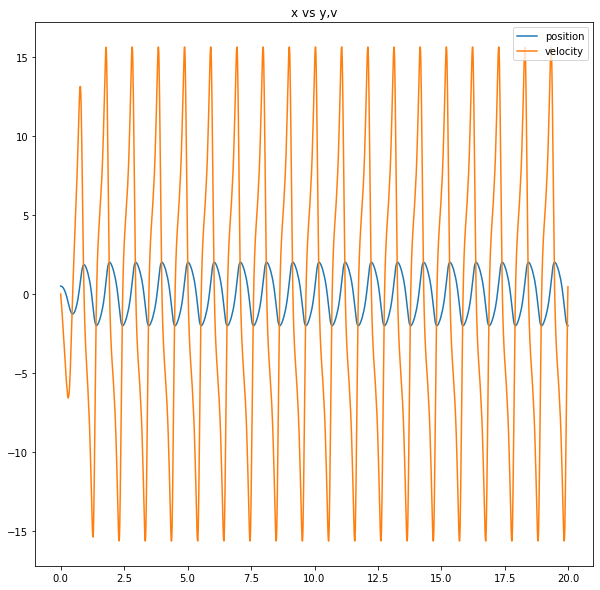

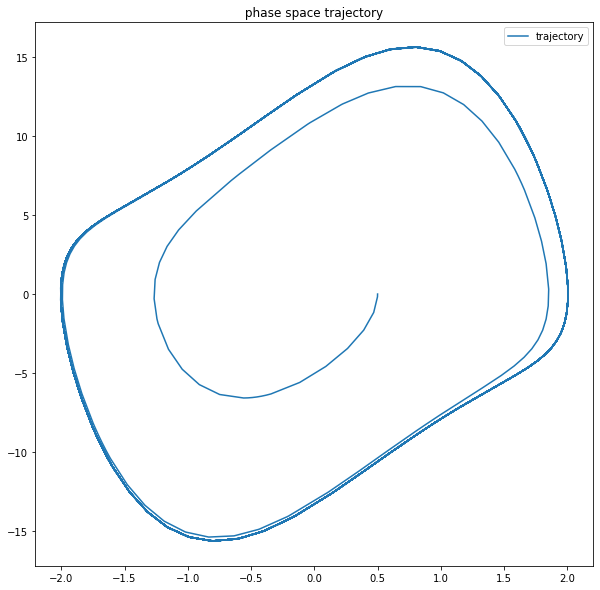

In [167]:
pos54 = yserk54[:,0]
der54 = yserk54[:,1]
x = xs54 


# plottings 
fig ,ax = plt.subplots(figsize = (10,10))
ax.plot(x,pos54,label = "position")
ax.plot(x,der54,label = "velocity")
ax.set_title("x vs y,v")
plt.legend(loc='upper right')
plt.show()

fig ,ax = plt.subplots(figsize = (10,10))
ax.plot(pos54,der54,label="trajectory")
plt.legend()
ax.set_title(" phase space trajectory ")
plt.show()